In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install sincnet_tensorflow

  Preparing metadata (setup.py) ... done
  Created wheel for sincnet_tensorflow: filename=sincnet_tensorflow-0.0.2-py3-none-any.whl size=5404 sha256=7ce7c052a0900cadd9c4ed307b23da2c15f505ee2a84437da94d5ea589644c3a
  Stored in directory: /root/.cache/pip/wheels/5b/33/d4/e06720531a144468feaef52783cc61e732bba7405780623fb3
Successfully built sincnet_tensorflow


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, LeakyReLU, BatchNormalization, Flatten, MaxPooling1D, Input
from sincnet_tensorflow import SincConv1D, LayerNorm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [4]:
# Función para cargar datos
def cargar_datos(ruta_datos_enfermos, ruta_datos_sanos):
    # Cargar datos de personas enfermas
    datos_enfermos = []
    etiquetas_enfermos = []
    for archivo in os.listdir(ruta_datos_enfermos):
        if archivo.endswith(".wav"):
            archivo_path = os.path.join(ruta_datos_enfermos, archivo)
            datos_audio = cargar_audio(archivo_path)
            datos_enfermos.append(datos_audio)
            etiquetas_enfermos.append(1)  # Etiqueta 1 para personas enfermas

    # Cargar datos de personas sanas
    datos_sanos = []
    etiquetas_sanos = []
    for archivo in os.listdir(ruta_datos_sanos):
        if archivo.endswith(".wav"):
            archivo_path = os.path.join(ruta_datos_sanos, archivo)
            datos_audio = cargar_audio(archivo_path)
            datos_sanos.append(datos_audio)
            etiquetas_sanos.append(0)  # Etiqueta 0 para personas sanas

    X = np.concatenate([datos_enfermos, datos_sanos], axis=0)
    y = np.concatenate([etiquetas_enfermos, etiquetas_sanos], axis=0)

    return X, y

In [5]:
import librosa
def cargar_audio(archivo_path):
    # Carga el archivo de audio usando librosa
    audio, _ = librosa.load(archivo_path, sr=50000)  # Asume una frecuencia de muestreo de 16000 Hz

    # Asegúrate de que los datos estén en el formato correcto (8000 puntos de datos)
    if len(audio) < 70000:
        # Si el audio es más corto, rellena con ceros
        audio = np.pad(audio, (0, 70000 - len(audio)))
    elif len(audio) > 70000:

        # Si el audio es más largo, truncalo
         audio = audio[:70000]

    # Formatea los datos para que tengan la forma (8000, 1)
    audio = audio.reshape((70000,1))

    return audio

In [6]:
# Rutas de las carpetas con datos de audio
ruta_enfermos = "/content/drive/MyDrive/PROYECTO_FINAL/Frases_enfermos_HM_duplicado/export"
ruta_sanos = "//content/drive/MyDrive/PROYECTO_FINAL/frases sanos + whitenoise sanos"

# Cargar datos
X, y = cargar_datos(ruta_enfermos, ruta_sanos)

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
import os

def contar_audios_en_directorio(directorio):
    contador = 0
    extensiones_de_audio = ['.wav', '.mp3', '.ogg', '.flac']  # Agrega más extensiones si es necesario

    for raiz, directorios, archivos in os.walk(directorio):
        for archivo in archivos:
            if any(archivo.endswith(extension) for extension in extensiones_de_audio):
                contador += 1

    return contador

# Directorio donde se encuentran los archivos de audio
directorio_dataset_enfermos = '/content/drive/MyDrive/PROYECTO_FINAL/Frases_enfermos_HM_duplicado/export'
directorio_dataset_sanos='/content/drive/MyDrive/PROYECTO_FINAL/frases sanos + whitenoise sanos'

# Contar archivos de audio en el directorio
cantidad_audios = contar_audios_en_directorio(directorio_dataset_enfermos)
print("Cantidad de archivos de audio en el dataset_enfermos:", cantidad_audios)
cantidad_audios_sanos = contar_audios_en_directorio(directorio_dataset_sanos)
print("Cantidad de archivos de audio en el dataset_sanos:", cantidad_audios_sanos)


Cantidad de archivos de audio en el dataset_enfermos: 1724
Cantidad de archivos de audio en el dataset_sanos: 1656


In [8]:
#DEMOSTRACION DE AUDIO ORIGINAL
from scipy.io import wavfile
AudioName = "/content/drive/MyDrive/PROYECTO_FINAL/Frases_enfermos_HM_duplicado/export/1040-phrase.wav" # Archivo de Audio

# Salida fs: Frecuencia de muestreo and data: Señal de audio -> int16
fs, Audiodata = wavfile.read(AudioName)
print(f'Duracion = {Audiodata.shape[0]/fs} , Frecuencia de Muestreo = {fs} [=] Muestras/Seg' \
      f', Wav format = {Audiodata.dtype}')

Duracion = 2.28794 , Frecuencia de Muestreo = 50000 [=] Muestras/Seg, Wav format = int16


In [9]:
#dEMOSTRACION DE AUDIO CON RUIDO BLANCO

from scipy.io import wavfile
AudioName = "/content/drive/MyDrive/PROYECTO_FINAL/Frases_enfermos_HM_duplicado/export/aumentado1_1040-phrase.wav" # Archivo de Audio

# Salida fs: Frecuencia de muestreo and data: Señal de audio -> int16
fs, Audiodata_noise = wavfile.read(AudioName)
print(f'Duracion = {Audiodata_noise.shape[0]/fs} , Frecuencia de Muestreo = {fs} [=] Muestras/Seg' \
      f', Wav format = {Audiodata_noise.dtype}')

Duracion = 2.28794 , Frecuencia de Muestreo = 50000 [=] Muestras/Seg, Wav format = int16


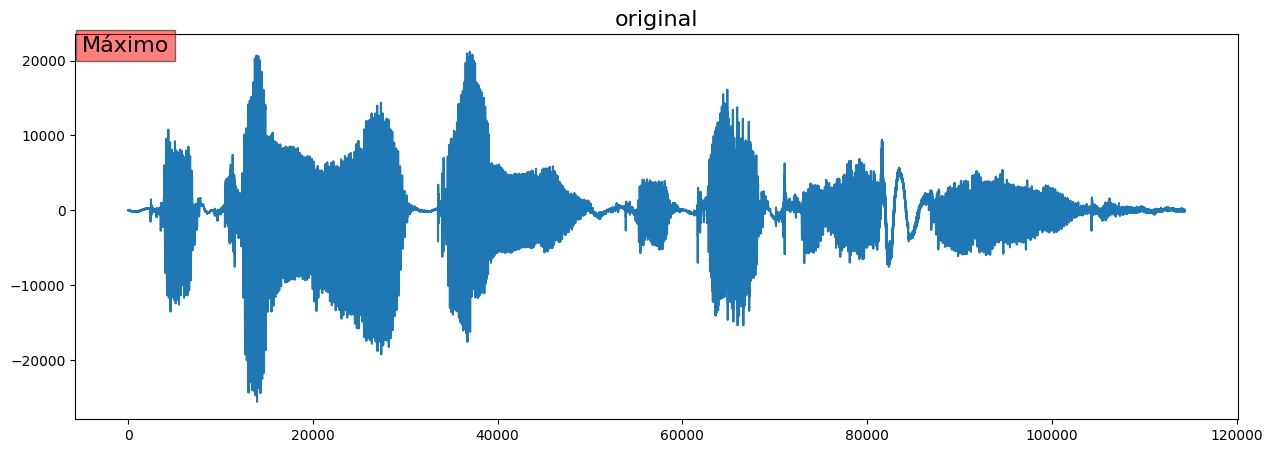

In [10]:
#GRAFICAR AUDIO ORIGINAL
import matplotlib.pyplot as plt #Libreria para realizar graficos

plt.rcParams['figure.figsize'] = (15, 5) # Definir el tamaño de graficas
plt.plot(Audiodata) # Audiodata es un numpy array
plt.text(0-5000, np.max(Audiodata), 'Máximo', fontsize = 16,bbox=dict(facecolor='red', alpha=0.5))
plt.title('original',size=16);


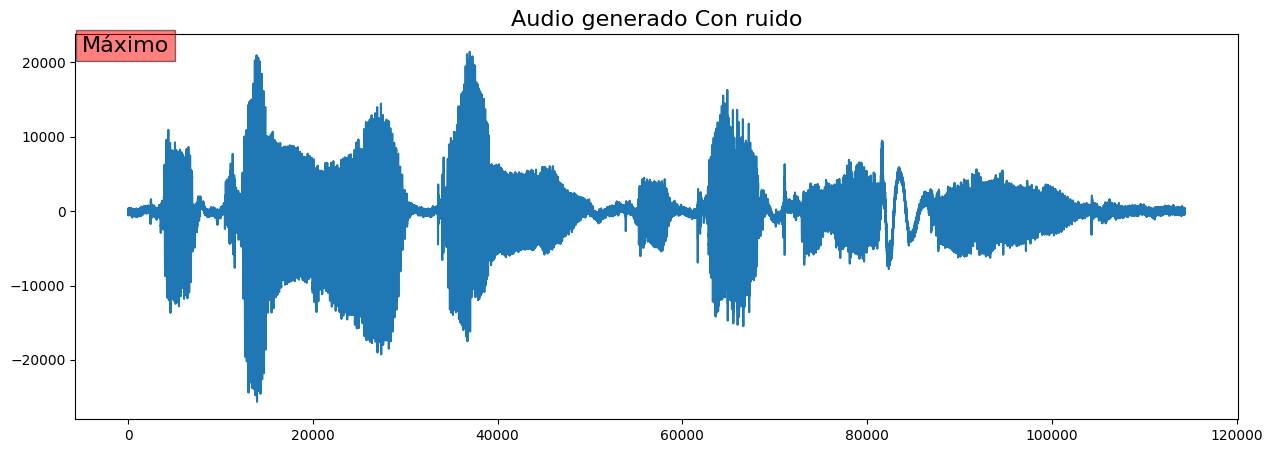

In [11]:
#GRAFICAR AUDIO GENERADO CON RUIDO BLANCO
plt.rcParams['figure.figsize'] = (15, 5) # Definir el tamaño de graficas
plt.plot(Audiodata_noise) # Audiodata es un numpy array
plt.text(0-5000, np.max(Audiodata_noise), 'Máximo', fontsize = 16,bbox=dict(facecolor='red', alpha=0.5))
plt.title('Audio generado Con ruido',size=16);


In [12]:
# Definir la arquitectura del modelo
out_dim = 50  # número de clases

sinc_layer = SincConv1D(N_filt=64, Filt_dim=129, fs=50000, stride=16, padding="SAME")

inputs = Input((70000, 1))
x = sinc_layer(inputs)
x = LayerNorm()(x)

x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling1D(pool_size=2)(x)


# Definición del modelo
x = Flatten()(x)
x = Dense(256)(x)
x = BatchNormalization(momentum=0.05, epsilon=1e-5)(x)
x = LeakyReLU(alpha=0.2)(x)

x = Dense(256)(x)
x = BatchNormalization(momentum=0.05, epsilon=1e-5)(x)
x = LeakyReLU(alpha=0.2)(x)


In [13]:
prediction = Dense(out_dim, activation='softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=prediction)

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
#history=model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Inicializar K-Folds cross-validator
kf = KFold(n_splits=5, shuffle=True)


In [14]:
#accuracy = model.evaluate(X_test, y_test)[1]
#print(f'Accuracy en datos de prueba: {accuracy}')

In [15]:
##from tqdm import tqdm

# Lista para almacenar las puntuaciones de validación cruzada
scores = []

# Realizar la validación cruzada con barra de progreso
#for train_index, test_index in tqdm(kf.split(X), total=kf.get_n_splits()):
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]

    # Entrenar el modelo
#    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

    # Evaluar el modelo en el conjunto de prueba
#    y_pred = np.argmax(model.predict(X_test), axis=-1)
#    score = accuracy_score(y_test, y_pred)
#    scores.append(score)

# Imprimir los resultados de la validación cruzada
#print("Precisión de validación cruzada: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores)))

In [16]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, recall_score, f1_score

# Listas para almacenar las métricas de evaluación
accuracy_scores = []
recall_scores = []
f1_scores = []

for train_index, test_index in tqdm(kf.split(X), total=kf.get_n_splits()):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print("Tamaño del conjunto de entrenamiento:", len(X_train))
    print("Tamaño del conjunto de prueba:", len(X_test))

    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

    # Evaluar el modelo en el conjunto de prueba
    y_pred = np.argmax(model.predict(X_test), axis=-1)

    # Calcular y almacenar las métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')  # Se especifica average='macro' para el cálculo del recall
    f1 = f1_score(y_test, y_pred, average='macro')          # Se especifica average='macro' para el cálculo del F1-score

    accuracy_scores.append(accuracy)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Imprimir las métricas de entrenamiento
    print("Pérdida de entrenamiento:", history.history['loss'])
    print("Precisión de entrenamiento:", history.history['accuracy'])


  0%|          | 0/5 [00:00<?, ?it/s]

Tamaño del conjunto de entrenamiento: 2704
Tamaño del conjunto de prueba: 676
Epoch 1/10
68/68 [==============================] - 92s 1s/step - loss: 1.0921 - accuracy: 0.7661 - val_loss: 2.5234 - val_accuracy: 0.3124
Epoch 2/10
68/68 [==============================] - 83s 1s/step - loss: 0.0832 - accuracy: 0.9773 - val_loss: 2.3303 - val_accuracy: 0.4344
Epoch 3/10
68/68 [==============================] - 83s 1s/step - loss: 0.0235 - accuracy: 0.9954 - val_loss: 0.8521 - val_accuracy: 0.7708
Epoch 4/10
68/68 [==============================] - 80s 1s/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 1.3375 - val_accuracy: 0.6765
Epoch 5/10
68/68 [==============================] - 88s 1s/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.2782 - val_accuracy: 0.7209
Epoch 6/10
68/68 [==============================] - 87s 1s/step - loss: 0.0053 - accuracy: 0.9982 - val_loss: 0.6845 - val_accuracy: 0.8189
Epoch 7/10
68/68 [==============================] - 86s 1s/step - loss: 0.0051 - a

 20%|██        | 1/5 [14:30<58:02, 870.55s/it]

Pérdida de entrenamiento: [1.092113733291626, 0.083188496530056, 0.02353486604988575, 0.006557915359735489, 0.0038250416982918978, 0.005329034756869078, 0.005063628312200308, 0.02369968593120575, 0.072701096534729, 0.06555473059415817]
Precisión de entrenamiento: [0.7660656571388245, 0.9773463010787964, 0.9953767657279968, 1.0, 1.0, 0.9981507062911987, 0.9990753531455994, 0.9926028847694397, 0.9754970073699951, 0.9791955351829529]
Tamaño del conjunto de entrenamiento: 2704
Tamaño del conjunto de prueba: 676
Epoch 1/10
68/68 [==============================] - 83s 1s/step - loss: 0.1576 - accuracy: 0.9528 - val_loss: 1.9829 - val_accuracy: 0.4621
Epoch 2/10
68/68 [==============================] - 89s 1s/step - loss: 0.0384 - accuracy: 0.9889 - val_loss: 0.4809 - val_accuracy: 0.8558
Epoch 3/10
68/68 [==============================] - 84s 1s/step - loss: 0.0067 - accuracy: 0.9995 - val_loss: 0.5971 - val_accuracy: 0.8226
Epoch 4/10
68/68 [==============================] - 83s 1s/step - l

 40%|████      | 2/5 [28:58<43:27, 869.07s/it]

Pérdida de entrenamiento: [0.15757963061332703, 0.03838448226451874, 0.0067333984188735485, 0.005431732162833214, 0.0025763383600860834, 0.001604490797035396, 0.001373776001855731, 0.0008386794361285865, 0.00041817003511823714, 0.000532540085259825]
Precisión de entrenamiento: [0.9528432488441467, 0.9889042973518372, 0.9995377063751221, 0.9990753531455994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Tamaño del conjunto de entrenamiento: 2704
Tamaño del conjunto de prueba: 676
Epoch 1/10
68/68 [==============================] - 81s 1s/step - loss: 0.0106 - accuracy: 0.9958 - val_loss: 0.1337 - val_accuracy: 0.9760
Epoch 2/10
68/68 [==============================] - 81s 1s/step - loss: 0.0361 - accuracy: 0.9884 - val_loss: 0.1855 - val_accuracy: 0.9519
Epoch 3/10
68/68 [==============================] - 82s 1s/step - loss: 0.0398 - accuracy: 0.9871 - val_loss: 3.7610 - val_accuracy: 0.4159
Epoch 4/10
68/68 [==============================] - 79s 1s/step - loss: 0.0327 - accuracy: 0.9880 - val_loss: 0.7

 60%|██████    | 3/5 [43:33<29:03, 871.54s/it]

Pérdida de entrenamiento: [0.010578429326415062, 0.036054179072380066, 0.03979270160198212, 0.03265270218253136, 0.0058274101465940475, 0.015135960653424263, 0.01918775774538517, 0.014566550962626934, 0.008746007457375526, 0.008015032857656479]
Precisión de entrenamiento: [0.9958391189575195, 0.9884420037269592, 0.9870550036430359, 0.9879796504974365, 0.9990753531455994, 0.9958391189575195, 0.994452178478241, 0.9949144721031189, 0.9963014125823975, 0.9972260594367981]
Tamaño del conjunto de entrenamiento: 2704
Tamaño del conjunto de prueba: 676
Epoch 1/10
68/68 [==============================] - 82s 1s/step - loss: 0.0198 - accuracy: 0.9935 - val_loss: 4.5338 - val_accuracy: 0.3993
Epoch 2/10
68/68 [==============================] - 81s 1s/step - loss: 0.0108 - accuracy: 0.9972 - val_loss: 1.6314 - val_accuracy: 0.6950
Epoch 3/10
68/68 [==============================] - 90s 1s/step - loss: 0.0292 - accuracy: 0.9898 - val_loss: 0.9283 - val_accuracy: 0.8226
Epoch 4/10
68/68 [===========

 80%|████████  | 4/5 [57:45<14:24, 864.16s/it]

Pérdida de entrenamiento: [0.019769499078392982, 0.010806374251842499, 0.029249027371406555, 0.014441382139921188, 0.006119603756815195, 0.006292411126196384, 0.004151262808591127, 0.00348469614982605, 0.0046427627094089985, 0.004247692413628101]
Precisión de entrenamiento: [0.9935275316238403, 0.9972260594367981, 0.9898289442062378, 0.9949144721031189, 0.9986130595207214, 0.9981507062911987, 0.9986130595207214, 0.9986130595207214, 0.9986130595207214, 0.9976884126663208]
Tamaño del conjunto de entrenamiento: 2704
Tamaño del conjunto de prueba: 676
Epoch 1/10
68/68 [==============================] - 90s 1s/step - loss: 0.0123 - accuracy: 0.9963 - val_loss: 1.0016 - val_accuracy: 0.7616
Epoch 2/10
68/68 [==============================] - 81s 1s/step - loss: 0.0123 - accuracy: 0.9977 - val_loss: 1.1973 - val_accuracy: 0.7800
Epoch 3/10
68/68 [==============================] - 82s 1s/step - loss: 0.0214 - accuracy: 0.9917 - val_loss: 0.2055 - val_accuracy: 0.9519
Epoch 4/10
68/68 [========

100%|██████████| 5/5 [1:12:15<00:00, 867.06s/it]

Pérdida de entrenamiento: [0.012349966913461685, 0.012308427132666111, 0.021440239623188972, 0.02421598881483078, 0.04190123453736305, 0.010490759275853634, 0.0067994920536875725, 0.00172332429792732, 0.007565639913082123, 0.0033205661457031965]
Precisión de entrenamiento: [0.9963014125823975, 0.9976884126663208, 0.9916782379150391, 0.992140531539917, 0.9884420037269592, 0.9963014125823975, 0.9976884126663208, 1.0, 0.9976884126663208, 0.9990753531455994]


In [19]:
# Imprimir los resultados de la validación cruzada
print("Precisión de validación cruzada: %0.2f (+/- %0.2f)" % (np.mean(accuracy_scores), np.std(accuracy_scores)))
print("Recall de validación cruzada: %0.2f (+/- %0.2f)" % (np.mean(recall_scores), np.std(recall_scores)))
print("F1-score de validación cruzada: %0.2f (+/- %0.2f)" % (np.mean(f1_scores), np.std(f1_scores)))

Precisión de validación cruzada: 0.92 (+/- 0.10)
Recall de validación cruzada: 0.92 (+/- 0.10)
F1-score de validación cruzada: 0.92 (+/- 0.11)


In [ ]:
mean_score = np.mean(scores)
std_score = np.std(scores)

# Graficar las puntuaciones individuales y el promedio
plt.figure(figsize=(10, 6))
plt.plot(scores, marker='o', linestyle='-', color='b', label='Puntuaciones individuales')
plt.axhline(y=mean_score, color='r', linestyle='--', label='Promedio de las puntuaciones')
plt.xlabel('Iteración de validación cruzada')
plt.ylabel('Puntuación de precisión')
plt.title('Puntuaciones de validación cruzada y promedio')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Graficar la precisión durante el entrenamiento
#plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
#plt.plot(history.history['val_accuracy'], label='Precisión de validación')
#plt.xlabel('Épocas')
#plt.ylabel('Precisión')
#plt.legend()
#lt.show()

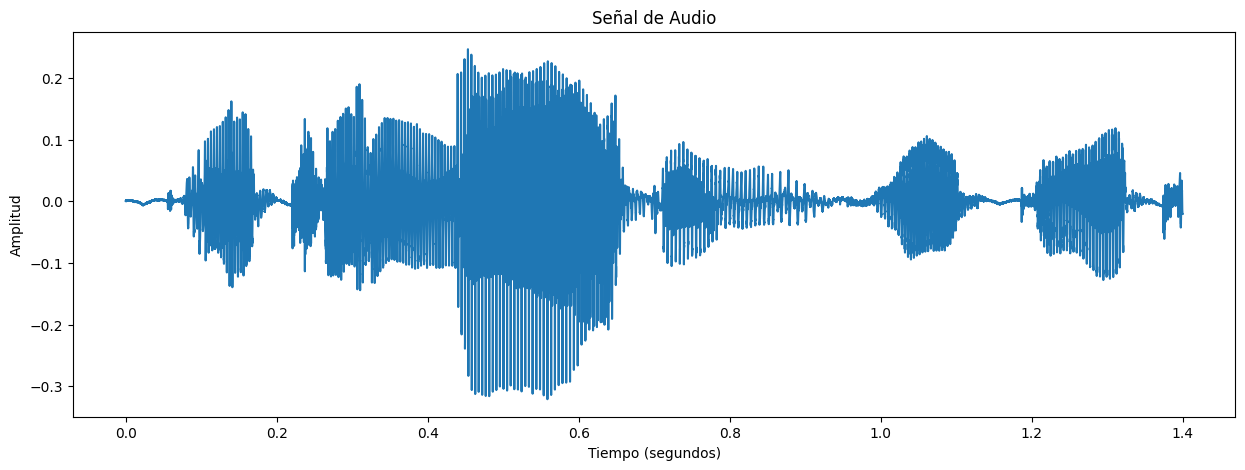

In [23]:
import librosa
import matplotlib.pyplot as plt
import numpy as np




def cargar_audio(archivo_path):
    # Carga el archivo de audio usando librosa
    audio, _ = librosa.load(archivo_path, sr=50000)  # Asume una frecuencia de muestreo de 16000 Hz

    # Asegúrate de que los datos estén en el formato correcto (8000 puntos de datos)
    if len(audio) < 70000:
        # Si el audio es más corto, rellena con ceros
        audio = np.pad(audio, (0, 70000 - len(audio)))
    elif len(audio) > 70000:

        # Si el audio es más largo, truncalo
         audio = audio[:70000]

    # Formatea los datos para que tengan la forma (8000, 1)
    audio = audio.reshape((70000,1))

    return audio

archivo_path = '/content/drive/MyDrive/PROYECTO_FINAL/frases sanos + whitenoise sanos/Copia de 1-phrase.wav'


# Ruta del archivo de audio
  # Reemplaza con la ruta correcta de tu archivo

# Cargar el audio
audio = cargar_audio(archivo_path)

# Crear un arreglo de tiempo para el eje x
tiempo = np.arange(0, len(audio)) / 50000  # La frecuencia de muestreo es 44000 Hz

# Graficar la señal de audio
plt.plot(tiempo, audio)
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.title('Señal de Audio')
plt.show()